In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from hmmlearn import hmm
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [2]:
df = pd.read_csv('../data/metro_interstate_traffic_volume_processed.csv')

X = df.drop(columns=['traffic_volume', 'traffic_volume_category'])
y = df['traffic_volume_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [3]:
day_of_week_categories = ['weekday', 'weekend']
time_of_day_categories = df['time_of_day'].unique()
weather_categories = df['weather'].unique()
temp_categories = df['temp'].unique()
traffic_categories = df['traffic_volume_category'].unique()

observations = list(product(day_of_week_categories, time_of_day_categories, weather_categories))
observations_map = {
    '_'.join(obs): i for i, obs in enumerate(observations)
}

state_map = {
    state: i for i, state in enumerate(traffic_categories)
}

In [4]:
def get_observation_index(row):
    weekday = 'weekend' if row['weekend'] == 1 else 'weekday'
    obs = f"{weekday}_{row['time_of_day']}_{row['weather']}"
    return observations_map[obs]

def get_sequence(data):
    return data.apply(get_observation_index, axis=1).values.reshape(-1, 1)

In [5]:
# Transition matrix
n_states = len(traffic_categories)
states_sequence = df['traffic_volume_category'].apply(lambda x: state_map[x]).values

transition_counts = np.zeros((n_states, n_states))
for (i, j) in zip(states_sequence[:-1], states_sequence[1:]):
    transition_counts[i, j] += 1

transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

# Emission matrix
n_observations = len(observations)
observations_sequence = get_sequence(df)

emission_counts = np.zeros((n_states, n_observations))
for state, obs in zip(states_sequence, observations_sequence):
    emission_counts[state, obs] += 1

emission_probs = emission_counts / emission_counts.sum(axis=1, keepdims=True)

# Start probability
start_counts = Counter(states_sequence)
start_probs = np.array([start_counts[state] for state in range(n_states)])
start_probs = start_probs / start_probs.sum()

print("Transition matrix:")
for row in transition_probs:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()
    
print("\nEmission matrix:")
for row in emission_probs:
    for prob in row:
        print(f"{prob:.2f}", end=' ')
    print()

print("\nStart probability:")
for prob in start_probs:
    print(f"{prob:.2f}", end=' ')
print()


Transition matrix:
0.78 0.21 0.01 0.00 
0.12 0.71 0.16 0.00 
0.09 0.07 0.69 0.15 
0.01 0.00 0.14 0.85 

Emission matrix:
0.12 0.11 0.05 0.07 0.08 0.22 0.13 0.06 0.07 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.08 0.06 0.03 0.06 0.04 0.06 0.03 0.02 0.04 0.01 0.07 0.05 0.02 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.03 0.03 0.01 0.01 0.01 0.10 0.06 0.03 0.03 0.02 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 
0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.15 0.14 0.06 0.07 0.04 0.03 0.03 0.01 0.02 0.02 0.04 0.04 0.01 0.03 0.02 0.00 0.00 0.00 0.01 0.00 0.06 0.06 0.02 0.03 0.02 0.01 0.01 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.01 0.14 0.19 0.07 0.11 0.10 0.01 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.06 0.09 0.03 0.05 0.04 

Start probability:
0.25 0.25 0.25 0.25 


In [6]:
model = hmm.CategoricalHMM(n_components=n_states)
model.startprob_ = start_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

In [7]:
test_sequence = get_sequence(X_test)
predicted = model.predict(test_sequence)
trues = y_test.apply(lambda x: state_map[x]).values

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=trues, mode='lines', name='True'))
fig.add_trace(go.Scatter(y=predicted, mode='lines', name='Predicted'))

fig.update_layout(
    title="Predicted vs True Values",
    xaxis_title="Index",
    yaxis_title="Value",
    legend=dict(x=0.02, y=0.98)
)
fig.show()

Accuracy: 0.71
F1: 0.69
[[2208  150   14    0]
 [1047  720  690    0]
 [ 112   50 1896  374]
 [  16    0  301 2061]]


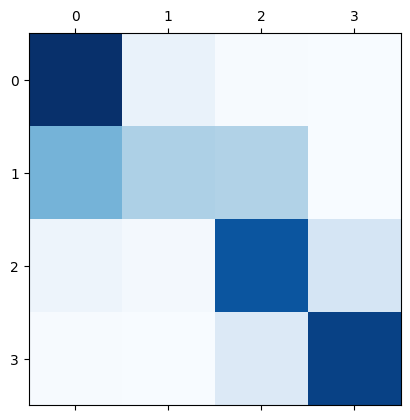

In [9]:
accuracy = accuracy_score(trues, predicted)
f1 = f1_score(trues, predicted, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")

cm = confusion_matrix(trues, predicted)
plt.matshow(cm, cmap='Blues')
print(cm)